In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import os
from typing import Dict, List, Tuple
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import Sequential, layers

In [2]:
df = pd.read_csv("/Users/sohinikar/M.Tech_Dissertation/Obfuscated-MalMem2022.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


# Data Cleaning

In [3]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [4]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [6]:
def clean_category(value):
    if pd.isnull(value):
        return value
    # Split at the first "-" and take only the first part
    family = value.split("-")[0]
    # Convert to lowercase and remove extra spaces
    family = re.sub(r'\s+', ' ', family.strip().lower())
    return family

df["Category"] = df["Category"].apply(clean_category)


In [7]:
X = df.drop(columns=["Category","Class"])   # all columns except Category are features
y = df["Category"]                  # Category is the target

In [8]:
X.shape

(58596, 52)

In [9]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [12]:
fnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(210, activation='tanh', kernel_initializer='he_normal'),  
    tf.keras.layers.Dense(150, activation='tanh', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),  # dropout to avoid overfitting
    tf.keras.layers.Dense(90, activation='tanh', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),  # dropout
    tf.keras.layers.Dense(4, activation='softmax')  # output layer for multiclass classification
])

# Compile the model
fnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)


# Summary
fnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 210)            │        11,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        31,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │        13,590 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,734 (221.62 KB)

 Trainable params: 56,734 (221.62 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min',
                  restore_best_weights=True, verbose=1)
]

In [16]:
start = time.time()
history = fnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)
end = time.time()

print(f"\nTraining time: {end - start:.3f} seconds")

Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8019 - loss: 0.4187 - val_acc: 0.8011 - val_loss: 0.4164
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7962 - loss: 0.4218 - val_acc: 0.7993 - val_loss: 0.4156
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8006 - loss: 0.4221 - val_acc: 0.8065 - val_loss: 0.4112
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8021 - loss: 0.4178 - val_acc: 0.8073 - val_loss: 0.4110
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8088 - loss: 0.4144 - val_acc: 0.8029 - val_loss: 0.4125
Restoring model weights from the end of the best epoch: 4.

Training time: 2.247 seconds


In [17]:
# Evaluate model
test_loss, test_acc = fnn_model.evaluate(X_test, y_test, verbose=0)
print(f"[FNN-MC] Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

# Predict probabilities & labels
y_prob = fnn_model.predict(X_test, verbose=0)   # shape: (N, 4)
y_pred = np.argmax(y_prob, axis=1)          # predicted classes
# shape: (N,)

[FNN-MC] Test loss: 0.4110 | Test accuracy: 0.8073


In [18]:
from sklearn.metrics import classification_report

class_names = ["benign", "ransomware", "spyware", "trojan horse"]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

      benign     1.0000    0.9998    0.9999      5860
  ransomware     0.5540    0.5603    0.5571      1958
     spyware     0.6375    0.6951    0.6651      2004
trojan horse     0.6557    0.5859    0.6188      1898

    accuracy                         0.8073     11720
   macro avg     0.7118    0.7103    0.7102     11720
weighted avg     0.8078    0.8073    0.8070     11720



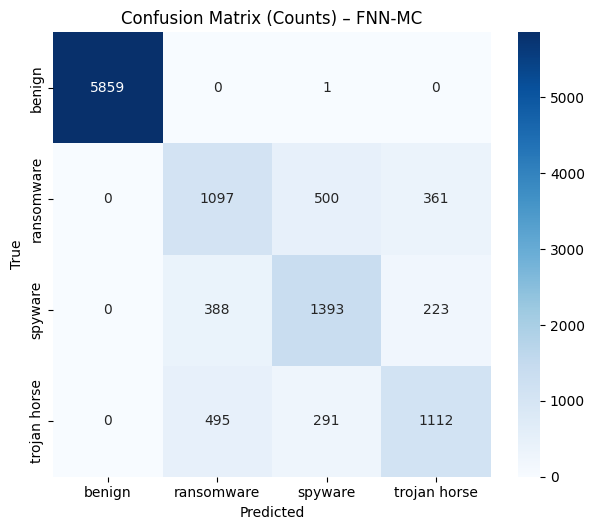

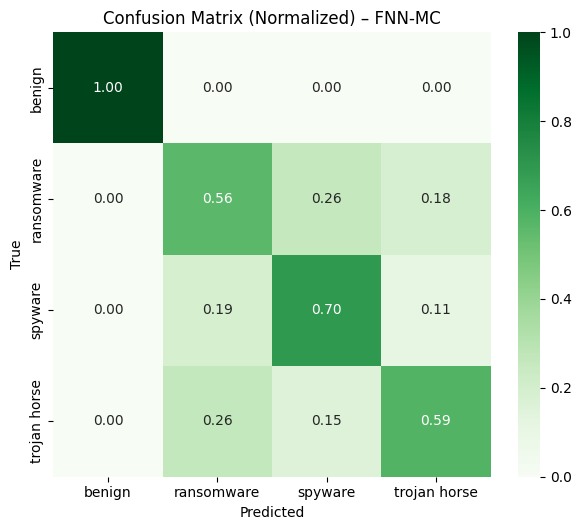

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6.2, 5.4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts) – FNN-MC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.2, 5.4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
plt.title("Confusion Matrix (Normalized) – FNN-MC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [20]:
X_train_lstm = np.expand_dims(X_train.astype(np.float32), axis=1)  # (N, 1, 52)
X_test_lstm  = np.expand_dims(X_test.astype(np.float32),  axis=1)  # (N, 1, 52)

In [53]:
num_classes = 4
lstm_model = Sequential([
    # timesteps=1, features=52
    tf.keras.Input(shape=(1, 52)),

    # LSTM layer 1 (use tanh for activation; recurrent_activation stays sigmoid by default)
    layers.LSTM(200, activation='tanh', return_sequences=True),
    layers.Dropout(0.5),

    # LSTM layer 2
    layers.LSTM(150, activation='tanh'),
    layers.Dropout(0.5),

    # Output for 4 classes
    layers.Dense(num_classes, activation='softmax')
], name="LSTM_MC")

lstm_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',            # sparse labels (0..3)
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

lstm_model.summary()

Model: "LSTM_MC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 200)         │       202,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,604 (1.58 MB)

 Trainable params: 413,604 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
start = time.time()
history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=5,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)
end = time.time()
print(f"\n[LSTM-MC] Training time: {end - start:.3f} seconds")

Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.6711 - loss: 0.6912 - val_acc: 0.7221 - val_loss: 0.5230
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7154 - loss: 0.5226 - val_acc: 0.7367 - val_loss: 0.5016
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7319 - loss: 0.5043 - val_acc: 0.7433 - val_loss: 0.4919
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7436 - loss: 0.4902 - val_acc: 0.7547 - val_loss: 0.4803
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.7521 - loss: 0.4839 - val_acc: 0.7582 - val_loss: 0.4745
Restoring model weights from the end of the best epoch: 5.

[LSTM-MC] Training time: 9.229 seconds


In [56]:
y_pred_lstm = lstm_model.predict(X_test_lstm)   # your trained LSTM model
y_pred_lstm = y_pred_lstm.argmax(axis=1)

# Convert y_test if one-hot encoded
if y_test.ndim > 1:
    y_test_labels = y_test.argmax(axis=1)
else:
    y_test_labels = y_test

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


In [57]:
from sklearn.metrics import classification_report

class_names = ["benign", "ransomware", "spyware", "trojan horse"]

print("\nClassification Report (LSTM-MC):")
print(classification_report(y_test, y_pred_lstm, target_names=class_names, digits=4))



Classification Report (LSTM-MC):
              precision    recall  f1-score   support

      benign     0.9998    0.9993    0.9996      5860
  ransomware     0.5008    0.4704    0.4851      1958
     spyware     0.6520    0.3777    0.4784      2004
trojan horse     0.4722    0.7123    0.5679      1898

    accuracy                         0.7582     11720
   macro avg     0.6562    0.6399    0.6327     11720
weighted avg     0.7715    0.7582    0.7546     11720



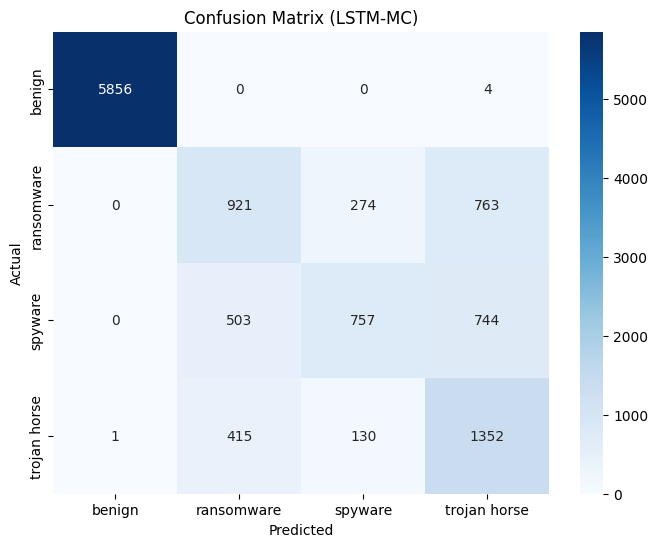

In [58]:
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LSTM-MC)")
plt.show()


# Federated Learning

In [37]:
import numpy as np
import tensorflow as tf
from typing import Dict, Optional, Tuple
from copy import deepcopy

# ---------- helper: fixed client assignment from test set ----------
def assign_fixed_clients_from_test(
    X: np.ndarray,
    y: np.ndarray,
    num_clients: int,
    base_total: int,
    base_clients: int,
    seed: int = 0,
    wrap: bool = True,
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Create a fixed client assignment with equal per-client size = base_total // base_clients.
    If wrap=True and dataset is shorter than base_total, indices repeat cyclically to fill.
    """
    X = np.asarray(X)
    y = np.asarray(y)
    assert len(X) == len(y), "X and y must have the same length."
    assert y.ndim == 1, "For sparse multiclass, y must be 1-D with integer class ids."
    assert base_clients > 0 and base_total > 0, "base_total/base_clients must be > 0."
    assert base_total % base_clients == 0, "base_total must be divisible by base_clients."
    assert num_clients == base_clients, "num_clients must equal base_clients for fixed sizing."

    per_user = base_total // base_clients
    n = len(X)

    rng = np.random.default_rng(seed)
    base_order = rng.permutation(n)

    if base_total <= n:
        idx = base_order[:base_total]
    else:
        if not wrap:
            raise ValueError(
                f"Need {base_total} samples but dataset has only {n}. "
                "Set wrap=True to repeat indices."
            )
        times = base_total // n
        rem = base_total % n
        idx = np.concatenate([np.tile(base_order, times), base_order[:rem]])

    assignment = {}
    start = 0
    for c in range(num_clients):
        end = start + per_user
        take = idx[start:end]
        assignment[f"client_{c+1}"] = {"X": X[take], "y": y[take]}
        start = end

    return assignment

# ---------- helper: model clone (no metrics on clients) ----------
def _clone_model_with_weights(model: tf.keras.Model) -> tf.keras.Model:
    clone = tf.keras.models.clone_model(model)
    clone.set_weights(model.get_weights())
    if not hasattr(model, "optimizer") or model.optimizer is None:
        raise ValueError("Global model must be compiled before FL.")
    opt = tf.keras.optimizers.deserialize(tf.keras.optimizers.serialize(model.optimizer))
    # No metrics on local clients to avoid Mean/Sum signature issues
    clone.compile(optimizer=opt, loss=model.loss, metrics=[])
    return clone

def _count_trainable_params(model: tf.keras.Model) -> int:
    return int(np.sum([np.prod(w.shape) for w in model.trainable_weights]))

def _layer_value_preview(model: tf.keras.Model, values_per_layer: int = 5):
    prev = {}
    for w in model.trainable_weights:
        arr = w.numpy().ravel()
        prev[w.name] = arr[:min(values_per_layer, arr.size)].tolist()
    return prev

def _weighted_fedavg(weights_list, sizes):
    total = float(np.sum(sizes))
    agg = [np.zeros_like(w) for w in weights_list[0]]
    for client_w, n in zip(weights_list, sizes):
        coef = (n / total) if total > 0 else 0.0
        for i, w in enumerate(client_w):
            agg[i] = agg[i] + coef * w
    return agg


In [50]:

def run_federated_round(
    global_model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray,
    model_kind: str,       # "fnn" or "lstm"
    users: int = 5,
    batch_size: int = 128,
    local_epochs: int = 1,
    rounds: int = 1,
    verbose: int = 1,
    log_params: bool = True,
    show_parameter_numbers: bool = True,
    values_per_layer: int = 5,
    eval_data: Optional[Tuple[np.ndarray, np.ndarray]] = None,
    client_assignment: Optional[Dict[str, Dict[str, np.ndarray]]] = None,
):
    """
    FedAvg with optional fixed client_assignment.
    Works for multiclass with sparse labels (int y) and 'sparse_categorical_crossentropy'.
    Expands inputs for LSTM: (N, T) -> (N, T, 1) if needed.
    """
    def _np(x): return x if isinstance(x, np.ndarray) else np.asarray(x)

    def _maybe_expand_for_lstm(x: np.ndarray) -> np.ndarray:
        # If model_kind is LSTM, ensure 3-D: (N, T, F). If 2-D, add feature dim.
        if model_kind.lower() == "lstm":
            x = np.asarray(x)
            if x.ndim == 2:
                return x[..., np.newaxis]          # (N, T, 1)
            elif x.ndim == 3:
                return x
            else:
                raise ValueError(f"Expected 2-D or 3-D input for LSTM, got shape {x.shape}")
        else:
            return np.asarray(x)                    # FNN path expects 2-D
    # ---------------- Prepare clients ----------------
    if client_assignment is None:
        # even split fallback
        n = len(X)
        idx = np.arange(n); np.random.shuffle(idx)
        parts = np.array_split(idx, users)
        clients = {f"client_{i+1}": {
                        "X": _maybe_expand_for_lstm(_np(X)[p]),
                        "y": _np(y)[p].astype(np.int64)}
                   for i, p in enumerate(parts)}
    else:
        clients = {}
        for cid, d in client_assignment.items():
            Xi = _maybe_expand_for_lstm(_np(d["X"]))
            yi = _np(d["y"])
            if yi.dtype.kind not in ("i", "u"):
                yi = yi.astype(np.int64)
            clients[cid] = {"X": Xi, "y": yi}

    report = {
        "rounds": rounds,
        "clients": list(clients.keys()),
        "samples_per_client": {cid: int(len(d["X"])) for cid, d in clients.items()},
        "per_round": [],
        "final_eval": None,
        "model_kind": model_kind,
        "trainable_params": None,
        "param_preview": None,
    }

    if show_parameter_numbers:
        report["trainable_params"] = _count_trainable_params(global_model)
    if log_params:
        report["param_preview"] = _layer_value_preview(global_model, values_per_layer)

    if verbose:
        print(f"[FL] Multiclass FedAvg: {rounds} rounds, {len(clients)} clients")
        print(f"[FL] Samples/client: {report['samples_per_client']}")

    # ---------------- Rounds ----------------
    for r in range(1, rounds + 1):
        if verbose:
            print(f"\n[FL] ----- Round {r}/{rounds} -----")

        global_weights = [w.copy() for w in global_model.get_weights()]
        client_weights, client_sizes, local_histories = [], [], {}

        for cid, data in clients.items():
            Xi, yi = data["X"], data["y"]

            local_model = _clone_model_with_weights(global_model)
            local_model.set_weights(global_weights)
            hist = local_model.fit(
                Xi, yi, batch_size=batch_size, epochs=local_epochs, verbose=0, shuffle=True
            )
            local_histories[cid] = {"loss": [float(x) for x in hist.history.get("loss", [])]}
            client_weights.append([w.copy() for w in local_model.get_weights()])
            client_sizes.append(int(len(Xi)))

        # FedAvg
        new_global = _weighted_fedavg(client_weights, client_sizes)
        global_model.set_weights(new_global)

        # Eval with the *global* model
        eval_metrics = None
        if eval_data is not None:
            Xte, yte = eval_data
            Xte = _maybe_expand_for_lstm(np.asarray(Xte))
            yte = np.asarray(yte)
            if yte.dtype.kind not in ("i", "u"):
                yte = yte.astype(np.int64)
            eval_vals = global_model.evaluate(Xte, yte, verbose=0)
            names = ["loss"] + [m.name if hasattr(m, "name") else str(m) for m in global_model.metrics]
            eval_metrics = {names[i]: float(eval_vals[i]) for i in range(len(eval_vals))}

        per_round_entry = {
            "round": r,
            "local_histories": local_histories,
            "eval": eval_metrics,
            "trainable_params": _count_trainable_params(global_model) if show_parameter_numbers else None,
            "param_preview": _layer_value_preview(global_model, values_per_layer) if log_params else None,
            "client_sizes": {c: s for c, s in zip(clients.keys(), client_sizes)},
        }
        report["per_round"].append(per_round_entry)

        if verbose and eval_metrics is not None:
            pretty = ", ".join([f"{k}: {v:.4f}" for k, v in eval_metrics.items()])
            print(f"[FL] Global eval -> {pretty}")

    if eval_data is not None and report["per_round"]:
        report["final_eval"] = deepcopy(report["per_round"][-1]["eval"])

    return report


In [51]:
# Assumptions:
# - fnn_model is exactly as you compiled:
#     loss='sparse_categorical_crossentropy',
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
# - X_test: shape (N, 52)
# - y_test: shape (N,), integer labels in {0,1,2,3}

users = 5
per_user = 46                             # choose your target size
base_total = users * per_user            # e.g., 5888
assignment_mc = assign_fixed_clients_from_test(
    X_test, y_test,
    num_clients=users,
    base_total=base_total,
    base_clients=users,
    seed=7,
    wrap=True,                           # repeat samples if N < base_total
)

report_mc = run_federated_round(
    global_model=fnn_model,              # compiled FNN (softmax over 4 classes)
    X=X_test, y=y_test,                  # ignored when client_assignment is provided
    model_kind="fnn",
    users=users,
    batch_size=128,
    local_epochs=1,
    rounds=5,
    verbose=1,
    log_params=True,
    show_parameter_numbers=True,
    values_per_layer=5,
    eval_data=(X_test, y_test),          # evaluate on the full test set
    client_assignment=assignment_mc,     # fixed shards from X_test
)


[FL] Multiclass FedAvg: 5 rounds, 5 clients
[FL] Samples/client: {'client_1': 46, 'client_2': 46, 'client_3': 46, 'client_4': 46, 'client_5': 46}

[FL] ----- Round 1/5 -----
[FL] Global eval -> loss: 0.8049

[FL] ----- Round 2/5 -----
[FL] Global eval -> loss: 0.8049

[FL] ----- Round 3/5 -----
[FL] Global eval -> loss: 0.8061

[FL] ----- Round 4/5 -----
[FL] Global eval -> loss: 0.8049

[FL] ----- Round 5/5 -----
[FL] Global eval -> loss: 0.8038


In [41]:
from pprint import pprint

rows = []
for r in report_mc["per_round"]:
    ev = r.get("eval") or {}
    row = {"round": r["round"]}
    for k in ["loss", "acc", "accuracy", "auc", "precision", "recall"]:
        if k in ev: row[k] = float(ev[k])
    rows.append(row)

pprint(rows)


[{'loss': 0.8067406415939331, 'round': 1},
 {'loss': 0.807081937789917, 'round': 2},
 {'loss': 0.8061433434486389, 'round': 3},
 {'loss': 0.805972695350647, 'round': 4},
 {'loss': 0.8040955662727356, 'round': 5}]


In [59]:
X_train_lstm.shape

(46876, 1, 52)

In [64]:
import numpy as np
import tensorflow as tf
from copy import deepcopy

def _ensure_lstm_shape_any(X, model):
    """
    Ensure rank-3 (N, 1, 52) given model.input_shape == (None, 1, 52).
    Works for NumPy arrays or tf.Tensors, even when eager is disabled.
    """
    ish = model.input_shape  # expect (None, 1, 52)
    _, T, F = ish
    assert (T, F) == (1, 52), f"Model expects (1,52); got {ish}"

    if isinstance(X, np.ndarray):
        if X.ndim == 2:   # (N,52) -> (N,1,52)
            return X[:, np.newaxis, :]
        elif X.ndim == 3:
            return X
        else:
            raise ValueError(f"Unexpected X shape {X.shape}")
    else:
        # tf.Tensor / Eager off safe path
        # X.shape is a tf.TensorShape (works in graph mode)
        if len(X.shape) == 2:  # (N,52) -> (N,1,52)
            N = tf.shape(X)[0]
            return tf.reshape(X, (N, 1, F))
        elif len(X.shape) == 3:
            return X
        else:
            raise ValueError(f"Unexpected X rank {len(X.shape)} for LSTM")

def _to_int_labels(y):
    # Works for NumPy or Tensor, no .numpy() calls
    if isinstance(y, np.ndarray):
        if y.dtype.kind not in ("i", "u"):
            return y.astype(np.int64)
        return y
    else:
        # Tensor path
        if y.dtype.is_integer:
            return y
        return tf.cast(y, tf.int64)

def _client_dataset(X, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(buffer_size= min(10000, int(tf.shape(y)[0]) if hasattr(y, "shape") else len(y)), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def run_fedavg_lstm_simple(
    global_model,
    X,
    y,
    client_assignment=None,
    users=5,
    batch_size=128,
    local_epochs=1,
    rounds=1,
    eval_data=None,
    verbose=1,
):
    """
    Minimal FedAvg for LSTM input (N,1,52), dataset-based training (graph/eager safe).
    Assumes global_model is compiled (e.g., loss='sparse_categorical_crossentropy').
    """
    # ---- Prepare clients ----
    def ensure_pair(Xi, yi):
        Xi = _ensure_lstm_shape_any(Xi, global_model)
        yi = _to_int_labels(yi)
        return Xi, yi

    if client_assignment is None:
        n = len(X) if isinstance(X, np.ndarray) else int(X.shape[0])
        idx = np.random.permutation(n)
        parts = np.array_split(idx, users)
        clients = {}
        for i, p in enumerate(parts):
            if isinstance(X, np.ndarray):
                Xi, yi = X[p], y[p]
            else:
                Xi, yi = tf.gather(X, p), tf.gather(y, p)
            Xi, yi = ensure_pair(Xi, yi)
            clients[f"client_{i+1}"] = {"X": Xi, "y": yi}
    else:
        clients = {}
        for cid, d in client_assignment.items():
            Xi, yi = ensure_pair(d["X"], d["y"])
            clients[cid] = {"X": Xi, "y": yi}

    if verbose:
        print(f"[FedAvg] {users} clients, {rounds} rounds")

    report = {"per_round": []}

    # ---- Rounds ----
    for r in range(1, rounds+1):
        if verbose: print(f"\n[Round {r}/{rounds}]")
        base_weights = deepcopy(global_model.get_weights())
        cw_list, sizes = [], []

        for cid, data in clients.items():
            Xi, yi = data["X"], data["y"]
            ds = _client_dataset(Xi, yi, batch_size)

            # local clone
            local = tf.keras.models.clone_model(global_model)
            local.set_weights(base_weights)
            # compile without metrics for speed/signature simplicity
            opt = tf.keras.optimizers.deserialize(tf.keras.optimizers.serialize(global_model.optimizer))
            local.compile(optimizer=opt, loss=global_model.loss, metrics=[])

            local.fit(ds, epochs=local_epochs, verbose=0)
            cw_list.append(local.get_weights())
            # size = number of samples
            size = int(Xi.shape[0]) if isinstance(Xi, np.ndarray) else int(Xi.shape[0])
            sizes.append(size)

        # FedAvg aggregation
        new_weights = []
        for i in range(len(base_weights)):
            stack = np.stack([cw[i] for cw in cw_list], axis=0)  # all numpy
            wavg = np.average(stack, axis=0, weights=sizes)
            new_weights.append(wavg)
        global_model.set_weights(new_weights)

        # Eval (optional)
        metrics = None
        if eval_data is not None:
            Xte, yte = eval_data
            Xte = _ensure_lstm_shape_any(Xte, global_model)
            yte = _to_int_labels(yte)
            ds_eval = tf.data.Dataset.from_tensor_slices((Xte, yte)).batch(batch_size)
            eval_vals = global_model.evaluate(ds_eval, verbose=0)
            names = ["loss"] + [m.name if hasattr(m, "name") else str(m) for m in global_model.metrics]
            if not isinstance(eval_vals, (list, tuple)):  # single loss
                eval_vals = [eval_vals]
                names = ["loss"]
            metrics = {names[i]: float(eval_vals[i]) for i in range(len(eval_vals))}
            if verbose:
                pretty = ", ".join([f"{k}={v:.4f}" for k, v in metrics.items()])
                print(f"  Eval: {pretty}")

        report["per_round"].append({"round": r, "eval": metrics})

    return report


In [65]:
report = run_fedavg_lstm_simple(
    global_model=lstm_model,
    X=X_train_lstm,           # shape (N,1,52) or (N,52)
    y=y_train,                # int class ids (or tensor)
    client_assignment=assignment_mc,  # optional
    users=5,
    rounds=5,
    batch_size=128,
    local_epochs=1,
    eval_data=(X_test_lstm, y_test),  # will be reshaped to (N,1,52) if needed
    verbose=1
)


[FedAvg] 5 clients, 5 rounds

[Round 1/5]
  Eval: loss=0.7593

[Round 2/5]
  Eval: loss=0.7585

[Round 3/5]
  Eval: loss=0.7597

[Round 4/5]
  Eval: loss=0.7605

[Round 5/5]
  Eval: loss=0.7607


In [55]:
print("Model expects:", lstm_model.input_shape)

Model expects: (None, 1, 52)
